In [ ]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [ ]:
!pip install -q gym ipdb

     |████████████████████████████████| 793 kB 7.7 MB/s 
     |████████████████████████████████| 380 kB 62.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.28 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [ ]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
gym.logger.set_level(40)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class deep_qnet(nn.Module):
  # in this part we define some features that describes the arcitecture of DQN

  def __init__(self,input_dim=4,output_dim=2,hidden_layer=64):
    

    super(deep_qnet, self).__init__()

    self.input_dim=input_dim
    self.output_dim=output_dim
    self.hidden=hidden_layer
    self.features=nn.Sequential(
        nn.Linear(self.input_dim,self.hidden),
        nn.ReLU(),
        nn.Linear(self.hidden,self.hidden),
        nn.ReLU()
    )
    self.adv=nn.Linear(self.hidden,self.output_dim)
    self.val = nn.Linear(self.hidden, 1)
  def forward(self,x):
    x=self.features(x)
    adv = self.adv(x)
    val = self.val(x)
    return val + adv - adv.mean(1, keepdim=True)

In [ ]:
class agent:
  def __init__(self,output_dim = 2,lr = 1e-3,batch_size = 32,gamma=0.99,epsilon=0.15):
    #we initialize our DQN
    self.output_dim=output_dim
    self.lr=lr
    self.batch_size=batch_size
    self.gamma=gamma
    self.epsilon=epsilon
    self.on_net=deep_qnet()
    self.on_net.train()
    self.targ_net=deep_qnet()
    self.update_targ_net()
    for param in self.targ_net.parameters(): param.requires_grad = False
    self.optimiser=optim.Adam(self.on_net.parameters(), lr=self.lr)
  def make_preact(self,state):
    # in this part of code we make an action prediction with DQN
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      return self.on_net(state).argmax(1).item()
  def make_preact_reverse(self,state):
    #in this part of code we make an action prediction with DQN that has the lowest value
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      return self.on_net(state).argmin(1).item()
  def make_final_act(self,state):
    # in this function we return act based on e greedy method
    if random.random()<self.epsilon:
      return random.randrange(self.output_dim)
    else:
      return self.make_preact(state)
  def make_final_act_reverse(self,state):
    # in this function we return act based on e greedy method in reverse method
    if random.random()<self.epsilon:
      return random.randrange(self.output_dim)
    else:
      return self.make_preact_reverse(state)
  def batch_samp(self,buffer):
    s, a, r, ns, t = zip(*random.sample(buffer, self.batch_size))
    f, l = torch.FloatTensor, torch.LongTensor
    return f(s), l(a), f(r), f(ns), f(t)
  def train_iter(self, buffer):
    state, action, reward, next_state, terminal = self.batch_samp(buffer)
    q_value = self.on_net(state)[range(self.batch_size), action]
    with torch.no_grad():
      next_state_action = self.on_net(next_state).max(1)[1] # online_net to get action for next_state
      next_qv = self.targ_net(next_state)[range(self.batch_size), next_state_action] # target_net to get Q
      target_qv = reward + self.gamma * (1 - terminal) * next_qv
    loss = (q_value - target_qv).pow(2).mean()
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    return loss.item()
  def update_targ_net(self):
    self.targ_net.load_state_dict(self.on_net.state_dict())
    
    
  


    



In [ ]:
normal_buffer=deque(maxlen=5000)
reverse_buffer=deque(maxlen=5000)
noisy_buffer=deque(maxlen=5000)

env = gym.make("CartPole-v0")
agent = agent()

Epsilon=0.15

100%|██████████| 15000/15000 [00:30<00:00, 494.89it/s]


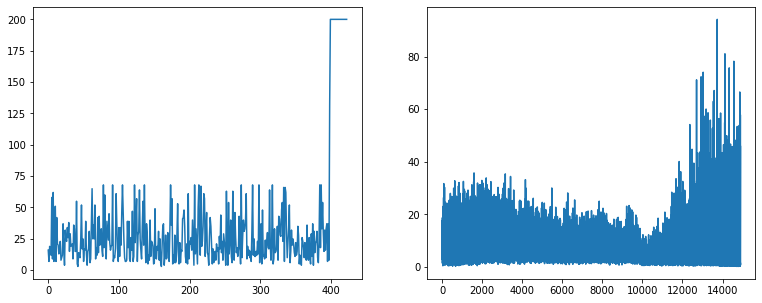

In [ ]:
rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in trange(15000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  if i <=10000:
    action = agent.make_final_act(state)
    next_state, reward, done, _ = env.step(action)
    normal_buffer.append((state, action, reward, next_state, done))
    #make reverse action
    action_reverse = agent.make_final_act_reverse(state)
    next_state_reverse, reward_reverse, done_reverse, _ = env.step(action_reverse)
    reverse_buffer.append((state, action_reverse, reward_reverse, next_state_reverse, done_reverse))
    #make noisy action
    noise = np.random.normal(0, .1, state.shape)
    noisy_state=noise+state
    action_noisy = agent.make_final_act(noisy_state)
    next_state_noisy, reward_noisy, done_noisy, _ = env.step(action)
    noisy_buffer.append((state, action_noisy, reward_noisy, next_state_noisy, done_noisy))
    
    state = next_state
    episode_reward += reward
    
    if done:
      state = env.reset()
      rewards.append(episode_reward)
      episode_reward = 0
      
    if i > 100:
      a=random.random()
      if a<0.33:
        loss.append(agent.train_iter(normal_buffer))
      if a>=0.33 and a<0.66:
        loss.append(agent.train_iter(reverse_buffer))
      if a>=0.66:
        loss.append(agent.train_iter(noisy_buffer))


    
    if i > 100 and i % 100 == 0:
      agent.update_targ_net()
  else:
    action = agent.make_final_act(state)
    next_state, reward, done, _ = env.step(action)
    normal_buffer.append((state, action, reward, next_state, done))
    state = next_state
    episode_reward += reward
    
    if done:
      state = env.reset()
      rewards.append(episode_reward)
      episode_reward = 0
      
    if i > 100:
        loss.append(agent.train_iter(normal_buffer))
 


    
    if i > 100 and i % 100 == 0:
      agent.update_targ_net()


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)

Epsilon=0.3